In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
import cv2
import pickle

# Define paths
train_dir = "D:/DATASET/CNN/steatosis/train"
test_dir = "D:/DATASET/CNN/steatosis/test"

In [2]:
# Data augmentation and resampling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

Found 38516 images belonging to 4 classes.
Found 38516 images belonging to 4 classes.


In [4]:
# Resampling
def oversample_minority_class(class_num, count):
    images = []
    labels = []
    class_dir = os.path.join(train_dir, str(class_num))
    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            img_path = os.path.join(class_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to read image: {img_path}")
                    continue
                img = cv2.resize(img, (299, 299))
                images.append(img)
                labels.append(class_num)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue
    sampled_images, sampled_labels = resample(images, labels, n_samples=count)
    return sampled_images, sampled_labels


In [5]:
# Class imbalance correction
oversampled_images = []
oversampled_labels = []
for class_num, count in [(0, 22752), (2, 22752), (3, 22752)]:  # Oversample classes 0, 2, 3 to match class 1
    sampled_images, sampled_labels = oversample_minority_class(class_num, count)
    oversampled_images.extend(sampled_images)
    oversampled_labels.extend(sampled_labels)

X_train, X_val, y_train, y_val = train_test_split(oversampled_images, oversampled_labels, test_size=0.2, random_state=42)

In [6]:
# Model definition
base_model = ResNet50(weights='imagenet', include_top=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode target labels
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_val_one_hot = to_categorical(y_val, num_classes=4)

# Train the model
model.fit(
    np.array(X_train), np.array(y_train_one_hot),
    epochs=3,
    batch_size=32,
    validation_data=(np.array(X_val), np.array(y_val_one_hot)))

# Save the model using pickle
with open("D:/DATASET/Models/model_steatosis.pickle", "wb") as s:
    pickle.dump(model, s)



Epoch 1/3
1707/1707 [==============================] - 41144s 24s/step - loss: 0.0249 - accuracy: 0.9930 - val_loss: 6.1388e-04 - val_accuracy: 0.9999
Epoch 2/3
1707/1707 [==============================] - 39564s 23s/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 0.0079 - val_accuracy: 0.9975
Epoch 3/3
1707/1707 [==============================] - 49773s 29s/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.1577 - val_accuracy: 0.9092


UnsupportedOperation: read

In [2]:
# Load the model using pickle
with open("D:/DATASET/Models/model_steatosis.pickle", "rb") as s:
    model = pickle.load(s)

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("Test accuracy:", test_acc)

# Save the model
model.save("D:/DATASET/Models/resnet50_steatosis_model.h5")

# Load the model
#loaded_model = load_model('resnet50_steatosis_model.h5')

1204/1204 - 6098s - loss: 16.6512 - accuracy: 0.0990 - 6098s/epoch - 5s/step
Test accuracy: 0.09897185862064362


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [12]:
# Function to make prediction on a single image
def predict_image(img_path, model):
    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((299, 299))  # Resize the image
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict using the model
    preds = model.predict(x)
    print('Predictions:', preds)

    # Get the index of the class with maximum probability
    max_prob_index = np.argmax(preds)
    
    # Define the NASH score mapping
    nash_scores = {
        0: "0: < 5% Steatosis",
        1: "1: 5–33% Steatosis",
        2: "2: 33–66% Steatosis",
        3: "3: >66% Steatosis"
    }
    
    # Get the NASH score corresponding to the maximum probability
    nash_score = nash_scores[max_prob_index]
    
    # Print the NASH score
    print('Predicted NASH score:', nash_score)
    


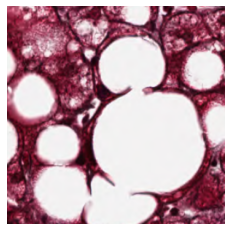

1/1 [==============================] - 0s 238ms/step
Predictions: [[9.9999905e-01 1.7749549e-08 9.1064044e-07 2.2026554e-09]]
Predicted NASH score: 0: < 5% Steatosis


In [14]:
# Path to the input image
img_path = "D:/DATASET/CNN/steatosis/train/2/5_39_73.png"

# Predict NASH score, calculate blue area, and display the image with blue contours
show_image(img_path)
predict_image(img_path, model)

In [3]:
# Load the model
#loaded_model = load_model("D:/DATASET/Models/resnet50_steatosis_model.h5")

# Function to apply masking annotation
def apply_masking(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299, 299))
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    
    if predicted_class == 0:
        print("Predicted NASH score: 0: < 5% Steatosis")
        cv2.putText(img, 'NASH Score: 0 (< 5% Steatosis)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    elif predicted_class == 1:
        print("Predicted NASH score: 1: 5–33% Steatosis")
        cv2.putText(img, 'NASH Score: 1 (5–33% Steatosis)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    elif predicted_class == 2:
        print("Predicted NASH score: 2: 33–66% Steatosis")
        cv2.putText(img, 'NASH Score: 2 (33–66% Steatosis)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        print("Predicted NASH score: 3: >66% Steatosis")
        cv2.putText(img, 'NASH Score: 3 (>66% Steatosis)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    cv2.imshow('Predicted Image with Annotation', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
# Example usage
#apply_masking("D:/DATASET/CNN/steatosis/train/1/2_142_25.png")


1/1 [==============================] - 1s 967ms/step
Predicted NASH score: 0: < 5% Steatosis


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:124: error: (-215:Assertion failed) bmi && width >= 0 && height >= 0 && (bpp == 8 || bpp == 24 || bpp == 32) in function 'FillBitmapInfo'
